In [5]:
using Pkg
Pkg.activate(joinpath(pwd(),".."))
using Random, Distributions, PrettyTables, Printf, Plots
Random.seed!(1234)

  Activating environment at `~/Desktop/ECON 627/Project.toml`


MersenneTwister(1234)

# Part (a)

In [6]:
const β = 1
const λ = 0.5

0.5

In [7]:
function data(n)
    Z = randn(n)
    ϵ = randn(n)
    V = randn(n)
    m = 4 .* (Z .- 0.7).^2

    U = λ .* V .+ ϵ
    X = m .+ V
    Y = β .* X .+ U

    return (Y = Y, X = X, Z = Z, m = m)
end

data (generic function with 1 method)

In [8]:
function gen_mz(X,Z,z)
    denominator = 0
    numerator = 0
    n = size(X,1)
    h = 1.06 * sqrt(var(Z)) * n^(-1/5)
    for i in 1:n
        Xi = X[i]
        Zi = Z[i]
        u = (Zi - z)/h
        Ki = abs(u) <=1 ? 3/4 * (1 - u)^2 : 0
        denominator += Ki
        numerator += Xi * Ki
    end
    mz_hat = numerator / denominator

    return (mz_hat = mz_hat)
end


gen_mz (generic function with 1 method)

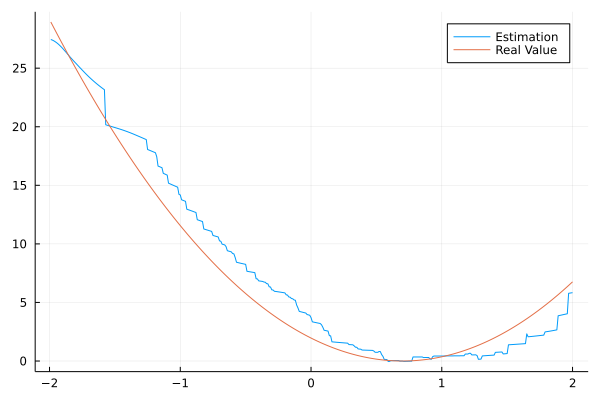

In [9]:
(Y,X,Z,m) = data(100)
result = zeros(400,3)


for i in 1:400
    zi = 0.01* i - 2
    result[i,1] = zi
    result[i,2] = gen_mz(X,Z,zi)
    result[i,3] = 4 * (zi - 0.7)^2
end

plot(result[:,1], result[:,2], label = "Estimation")
plot!(result[:,1], result[:,3], label = "Real Value")

From the graph, we can see that the estimated value is very close to the real value. So we can conclude that our estimator is accurate.

# Part (b)

In [10]:
function est2SLS(y, x, z)
    # Set some parameter
    n = size(y,1)
    Q = (z'* x)/n
    W = inv(z' * z/n)

    #Beta
    beta2SLS = (Q' * W * Q)^(-1) * Q' * W * (z' * y)/n

    # Asymptotic variance and standard error  
    u = y - x * beta2SLS
    zu = z .* u
    Omega = (zu' * zu)/n

    var = (Q' * W * Q)^(-1) * Q' * W * Omega * W * Q * (Q' * W * Q)^(-1)
    
    sd2SLS = sqrt(var)


    return (beta2SLS=beta2SLS, sd2SLS = sd2SLS)
end

est2SLS (generic function with 1 method)

In [21]:
result = zeros(10000,9)
cv =  quantile(Normal(0,1), 1 - 0.05/2)
for r in 1:10000
    (Y,X,Z,m) = data(100)
    n = size(X,1)
    mz_est = zeros(n)
    for i in 1:n
        Zi = Z[i]
        mz_est[i] = gen_mz(X,Z,Zi)
    end
    (betaIV, sdIV) = est2SLS(Y,X,Z)
    result[r,1] = betaIV - β
    result[r,2] = sdIV
    result[r,3] = abs(betaIV - β) < cv * sdIV/sqrt(n) ? 1 : 0

    (betam, sdm) = est2SLS(Y,X,m)
    result[r,4] = betam - β
    result[r,5] = sdm
    result[r,6] = abs(betam - β) < cv * sdm/sqrt(n)  ? 1 : 0

    (betam_hat, sdm_hat) = est2SLS(Y,X,mz_est)
    result[r,7] = betam_hat - β
    result[r,8] = sdm_hat
    result[r,9] = abs(betam_hat - β) < cv * sdm_hat/sqrt(n)  ? 1 : 0
end

table = ["Mean Bias" mean(result[:,1]) mean(result[:,4]) mean(result[:,7]) ; "Mean Standard Error" mean(result[:,2]) mean(result[:,5]) mean(result[:,8]) ; "Coverage Probability" mean(result[:,3]) mean(result[:,6]) mean(result[:,9])]

header = [" ", "2SLS", "Infeasible", " Feasible"]
pretty_table(table; header = header)


┌──────────────────────┬──────────────┬─────────────┬─────────────┐
│                      │         2SLS │  Infeasible │    Feasible │
├──────────────────────┼──────────────┼─────────────┼─────────────┤
│            Mean Bias │ -0.000321709 │ -1.59662e-5 │ 0.000211608 │
│  Mean Standard Error │     0.262707 │    0.109792 │    0.111996 │
│ Coverage Probability │       0.9706 │       0.923 │      0.9271 │
└──────────────────────┴──────────────┴─────────────┴─────────────┘


From the table we can see that all three methods are accurate, i.e., they have very low bias. As for efficiency, the infeasible approach and feasible approach have lower standard than 2SlS, so we can conclude that the efficient IV indeed improve efficiency. However, it seems that the efficient IV doesn't help much on converage probability. With efficient IV approach, we actually have lower coverage probability.